# AISEL -- Pedestrian Detector 
based on the PHD Thesis of Michael Greiffenhagen: "Engineering, Statistical Modeling and Performance Characterization of a Real-Time Dual Camera Surveillance System" Erlangen 2001
## Module 4: Feature Generation and Pedestrian Location Estimation

In [1]:
import os
import cv2
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.spatial import distance
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle

import pyro
import torch


import pyro.infer
import pyro.optim
import pyro.distributions as dist

%matplotlib notebook

In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

Load pedestrian video file from epfl from https://www.epfl.ch/labs/cvlab/data/data-pom-index-php/.

## Part 1: Feature Generation
Generate regions of interests, where potential pedestrians could  be located with quantifiable probabilites for false alarm and miss detections

In [2]:
!wget https://github.com/ccc-frankfurt/aisel-hands-on/blob/main/data/epflpedestshort.avi?raw=true

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/thraki/.wget-hsts'. HSTS will be disabled.
--2020-11-09 17:13:15--  https://github.com/ccc-frankfurt/aisel-hands-on/blob/main/data/epflpedestshort.avi?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ccc-frankfurt/aisel-hands-on/raw/main/data/epflpedestshort.avi [following]
--2020-11-09 17:13:15--  https://github.com/ccc-frankfurt/aisel-hands-on/raw/main/data/epflpedestshort.avi
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ccc-frankfurt/aisel-hands-on/main/data/epflpedestshort.avi [following]
--2020-11-09 17:13:15--  https://raw.githubusercontent.com/ccc-frankfurt/aisel-hands-on/main/data/epflpedestshort.avi


In [3]:
file ='./epflpedestshort.avi?raw=true'
cap = cv2.VideoCapture(file)

In Module 1 we introduced the illumination invariant normalised color channels r and g. We will use them as input to the background modelling.

In [4]:
def get_normalised_channels(img, pix=None):
    """Extract BGR channel of an image and return normalised r and g channels."""
    if pix:
        b,g,r = img[pix[0]][pix[1]]
    else:
        b,g,r = cv2.split(img)
    # Intensities are stored as int8, upcast for mathematical operations
    b = b.astype('int16');g = g.astype('int16');r = r.astype('int16')
    # Calculate vectorised sum over all channels
    rgb = np.add(r,np.add(b,g))
    # Calculate vectorised normalised channels
    r_norm = np.divide(r,rgb)
    g_norm = np.divide(g,rgb)
    return r_norm, g_norm

In [5]:
def get_cov(r_norm_vid, g_norm_vid):
    """Input wo matrices containing tuples, calulate elementwise the covariance and return the inverse of covariance matrices."""
    # Not vectorised for demo reasons, in production-> vectorise all numpy operations
    x,y = r_norm_vid[0].shape
    result = []
    last_inv_cov = None
    for i in range(x):
        for j in range(y):
            r_norm_pix = [r[i,j] for r in r_norm_vid]
            g_norm_pix = [g[i,j] for g in g_norm_vid]
            cov = np.cov(r_norm_pix,g_norm_pix)
            #cov = np.cov(r_norm_pix[~np.isnan(r_norm_pix)],g_norm_pix[~np.isnan(g_norm_pix)])
            ## hack to deal with non invertible cov matrices, replace with noise
            try:
                inv_cov =  np.linalg.inv(cov)
                last_inv_cov = inv_cov
            except:
                print("picked last cov mat @",i,j)
                inv_cov = last_inv_cov                          
            result.append(inv_cov)
    result = np.array(result)
    return result,(x,y)

In [6]:
def get_mahaldist(mu_b_arr,mu_c_arr,inv_cov_arr):
    "Returns mahalanobis distance measure for matrices of tuples and one matrix of 2X2 inverse covariance matrices"
    ## Not vectorised for demo reasons: In production-> vectorise all numpy operations
    x,y,z = mu_c.shape   
    result = []
    for i in range(x):
        for j in range(y):         
            d2 = distance.mahalanobis(mu_b_arr[i][j],mu_c_arr[i][j],inv_cov_arr[i][j])
            result.append(d2)
    return np.reshape(result,(x,y))


In [7]:
# containers to track evolution of mean
r_norm_vid = []; g_norm_vid = []

# limit frames to the first appearing in the video
i_frame=0
cap = cv2.VideoCapture(file)

success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    # our main call to get normalised channels
    r_norm, g_norm  = get_normalised_channels(frame)
    
    r_norm_vid.append(r_norm)
    g_norm_vid.append(g_norm)
    
    i_frame=i_frame+1
    #if i_frame>1000: # limit frames to the first appearing in the video
    #    break
    

Now build our candidate for the background mean estimate $\mu_b$

In [8]:
mu_b = np.stack((np.nanmean(r_norm_vid,axis=0),np.nanmean(g_norm_vid,axis=0)),axis=2)

In [9]:
inv_cov_mat, cov_shape = get_cov(r_norm_vid, g_norm_vid)

In [10]:
cov_mat_2d = np.reshape(inv_cov_mat, (cov_shape[0], cov_shape[1],2,2) )

In [11]:
## Loop over the video and save for constant mu_b and constant covariance matrix 
cap = cv2.VideoCapture(file)

d2_container = {}
mu_c_r_container = {}

i_frame = 0

success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    if i_frame > 400:
        break
   
    r_norm, g_norm  = get_normalised_channels(frame)    
    
    mu_c = (r_norm, g_norm)
    mu_c = np.stack((r_norm,g_norm),axis=2)
    mu_c_r_container[i_frame] = mu_c
    
    d2 = get_mahaldist(mu_b,mu_c, cov_mat_2d)
    d2_container[i_frame] = d2
    
    i_frame = i_frame+1
    
    
cap.release()
cv2.destroyAllWindows()

Identify Region of Interests (ROI) that could potentially contain pedestrians with quantifiable probabilites for false alarms $\alpha_f$ and miss-detection $\alpha_m$. 


A pedestrian may be modelled with a cylinder, which projection on a 2D plane can be approximated/calculated.
We assume pedestrians are upright and start with a index function that identifies lines in y-direction with changinge consequent pixels.

In [12]:
def get_active_areas(img, threshold = 20, max_single_pix_thres = 5, mean_pix_thres = 1,  min_height = 49, max_height = 50, min_y_step =5): # this is the region of interest algorithm
    
    
    """ get active areas from 2D array of mahalabonis distances"""
    """ min_y_step is the minima step in y to scan the line along the y axis """
    
    ny_pix = img.shape[0]
    nx_pix = img.shape[1]
    
    y_line_estimates = []
    
    for i in range(nx_pix):
        x1=i;x2=i+1
        y_line_est = np.zeros(img.shape,dtype=bool)
        for j in range(ny_pix): # Sub-sectors
            if j % min_y_step == 0:
                for height_guess in range(min_height,max_height):
                    cand = img[j:height_guess+j-1,x1:x2]
                    d2_sum = cand.flatten().sum()
                    max_d2 = max(cand.flatten())
                    mean_pix = np.mean(cand.flatten())

                    if d2_sum > threshold and max_d2 > max_single_pix_thres and mean_pix_thres < mean_pix: 
                        y_line_est[j:height_guess+j-1,x1:x2] = True
                        y_line_estimates.append( y_line_est )
                    
    return y_line_estimates

In [13]:
d2_frame = d2_container[200]

In [14]:
y_line_estimates = get_active_areas(d2_frame,threshold = 40, max_single_pix_thres = 5, mean_pix_thres = 1, min_height = 10, max_height = 50, min_y_step = 5)

In [15]:
len(y_line_estimates)

1013

In [16]:
areas_of_interest_cont = np.zeros(y_line_estimates[0].shape,dtype=bool)

In [17]:
for y_line in y_line_estimates:
    areas_of_interest_cont = np.ma.mask_or(areas_of_interest_cont ,y_line) 

<IPython.core.display.Javascript object>


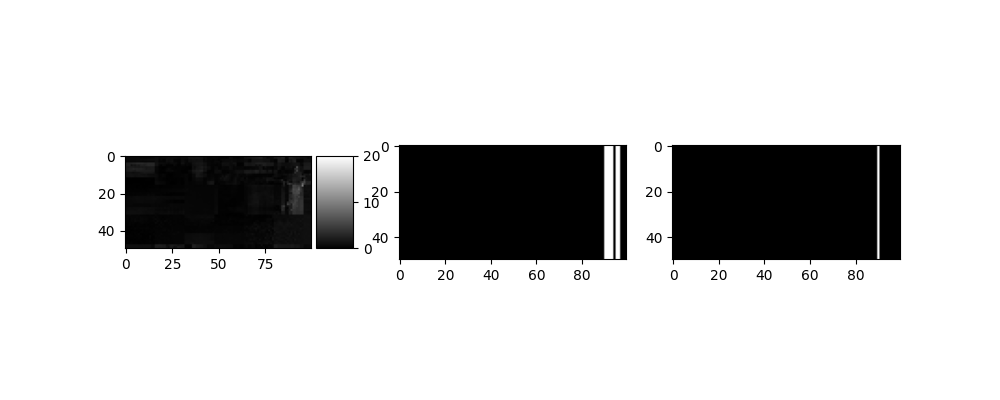

In [18]:
fig,ax = plt.subplots(1,3,figsize=(10, 4))
ax_handle = ax[0].imshow(d2_frame,cmap="gray",vmin=0, vmax=20)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax_handle,cax=cax)

ax[1].imshow(areas_of_interest_cont,cmap="gray")
ax[2].imshow(y_line_estimates[4],cmap="gray",vmin=0, vmax=1)

Let us have a look at the intensitiy profile for a region (or line) of interest

In [19]:
line_mask = y_line_estimates[2]

In [20]:
x_non_zero = np.nonzero(np.any(line_mask != 0, axis=0))[0][-1]

In [21]:
x_non_zero

90

In [22]:
d2_frame[:,x_non_zero]

array([2.20893394, 2.08498819, 2.34756487, 2.20827307, 1.51018344,
       1.37411296, 0.7428067 , 0.63706045, 0.70895235, 1.02728478,
       1.97494533, 1.65909522, 2.26895071, 2.73726679, 2.31909146,
       2.59678969, 5.2905214 , 5.12741807, 6.01939243, 5.41102567,
       5.28479522, 4.10018148, 3.9602573 , 3.81764119, 3.79354955,
       4.44682924, 5.46271499, 4.84966732, 4.83152374, 3.97671218,
       3.85818362, 3.93090613, 1.02955651, 1.05504887, 1.00171373,
       1.05075045, 1.20470771, 1.15917756, 1.22953072, 1.07020207,
       1.20189203, 0.98996174, 0.77803255, 0.86222588, 1.22096064,
       0.90509046, 0.95495419, 1.30223937, 2.0353538 , 1.94959984])

<IPython.core.display.Javascript object>


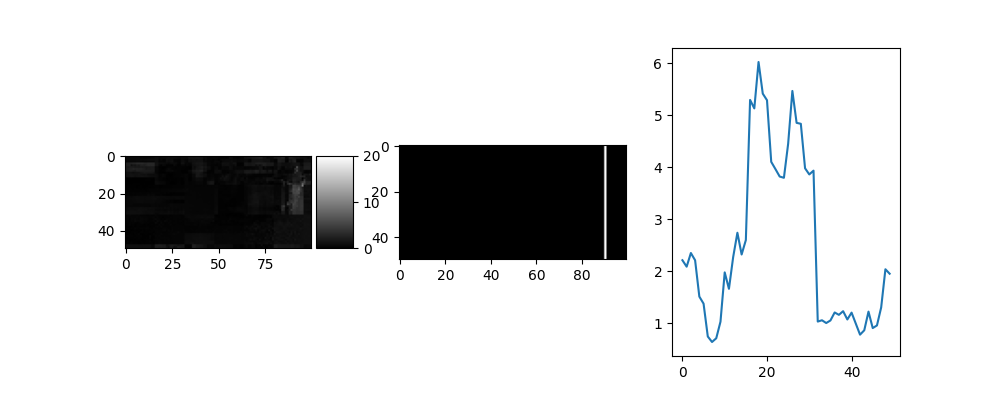

In [23]:
fig,ax = plt.subplots(1,3,figsize=(10, 4))
ax_handle = ax[0].imshow(d2_frame,cmap="gray",vmin=0, vmax=20)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax_handle,cax=cax)

ax[1].imshow(line_mask,cmap="gray")
ax[2].plot(d2_frame[:,x_non_zero])


Features for the location estimation of pedestrian should rely on assumption you can make on the shape of the objects of interests

Let us get the active pixels orthogonal to the ones found in the y direction as ROI in x direction as well

In [24]:
def get_feature_est(img, y_line_estimates, threshold = 20, max_single_pix_thres = 2, median_pix_thres = 1, min_width=2, max_width=20):  # this is the region of interest algorithm
    """Get cylinder shaped projection estimates in 2D"""
    ny_pix = img.shape[0]
    nx_pix = img.shape[1]
    ped_cylinder_estimates = []
    
    for y_line_m in y_line_estimates: 
        x_non_zero = np.nonzero(np.any(y_line_m != 0, axis=0))[0][-1]
        ped_cylinder_est = np.zeros(img.shape)
        
        #print (x_non_zero)
        for j in range(ny_pix):
            y1=j;y2=j+1
            if y_line_m[y1:y2,x_non_zero] == 1:
                 
                for width_guess in range(min_width, max_width):
                
                    ROI_2 = img[y1:y2, x_non_zero-int(width_guess/2):int(width_guess/2)+x_non_zero-1] 
                    d2_sum = ROI_2.flatten().sum()
                    
                    if len(ROI_2.flatten()) > 0:
                        max_d2 = max(ROI_2.flatten())
                        median_d2 =np.median(ROI_2.flatten())
                    else:
                        max_d2 = 0
                        mean_d2 = 0

                    if d2_sum > threshold and max_d2 > max_single_pix_thres and median_d2 > median_pix_thres: 

                        ped_cylinder_est[y1:y2, x_non_zero-int(width_guess/2):x_non_zero+int(width_guess/2)] = 1
                
                
        if np.sum(ped_cylinder_est) > 0:           
            ped_cylinder_estimates.append(ped_cylinder_est)
            
    return ped_cylinder_estimates
        

In [25]:
len(y_line_estimates)

1013

In [26]:
ped_cylinder_estimates = get_feature_est(d2_frame,y_line_estimates, threshold = 10, max_single_pix_thres = 4, median_pix_thres = 2, min_width=2, max_width=50)

<IPython.core.display.Javascript object>


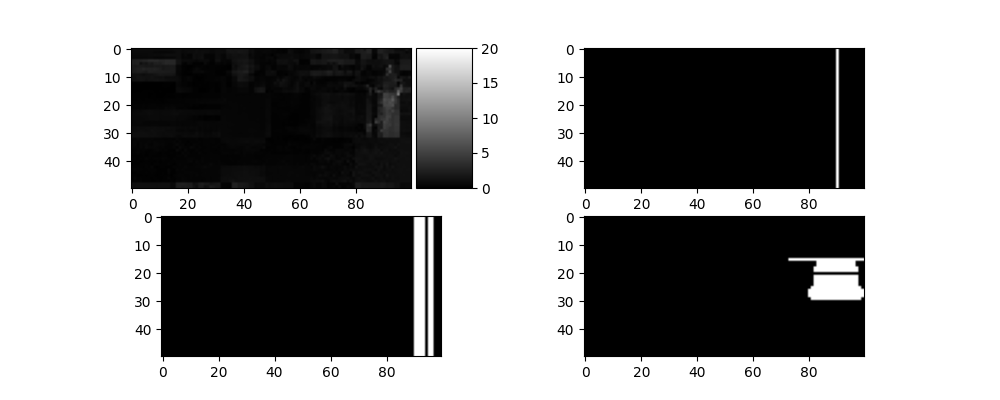

In [27]:
fig,ax = plt.subplots(2,2,figsize=(10, 4))
ax_handle = ax[0][0].imshow(d2_frame,cmap="gray",vmin=0, vmax=20)
divider = make_axes_locatable(ax[0][0])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax_handle,cax=cax)

ax[1][0].imshow(areas_of_interest_cont,cmap="gray",vmin=0, vmax=1)

n_est = 50

ax[0][1].imshow(y_line_estimates[n_est],cmap="gray",vmin=0, vmax=1)

ax[1][1].imshow(ped_cylinder_estimates[n_est],cmap="gray",vmin=0, vmax=1)

Approximate pedestrians as 3D cylinder objects; 3D Zylinder objects can be described by 3 parameters: a height $H_p$, a Radius $R_p$ and a foot position estimation $LOC_{foot} =\begin{pmatrix} x_{foot} & y_{foot} & z_{foot}  \end{pmatrix}$ 


To get an estimate on the foot position in 2D image space on $x_{foot}$,  $y_{foot}$ (note that this is a different coordinate system than in the 3D case). 

In [28]:
foot_head_est_y = [np.where(np.any(ped, axis=1))[0][[0, -1]]  for ped in ped_cylinder_estimates]

In [29]:
foot_head_est_x = [np.nonzero(np.any(y_line_m != 0, axis=0))[0][-1] for y_line_m in  y_line_estimates]

In [30]:
head_pos = [f[0] for f  in foot_head_est_y]

In [31]:
foot_pos = [f[1] for f  in foot_head_est_y]

<IPython.core.display.Javascript object>


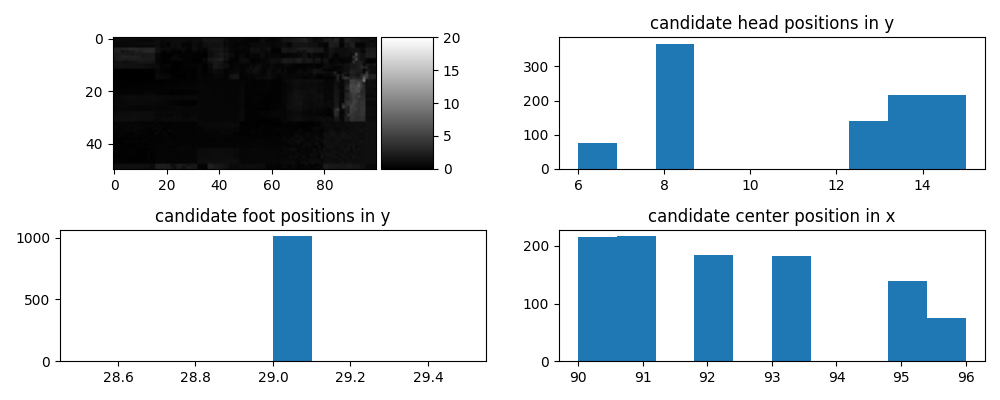

In [32]:
fig,ax = plt.subplots(2,2,figsize=(10, 4))
ax_handle = ax[0][0].imshow(d2_frame,cmap="gray",vmin=0, vmax=20)
divider = make_axes_locatable(ax[0][0])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax_handle,cax=cax)
ax[1][0].set_title("candidate foot positions in y")
ax[1][0].hist(foot_pos)

ax[0][1].set_title("candidate head positions in y")
ax[0][1].hist(head_pos)
ax[1][1].set_title("candidate center position in x")
ax[1][1].hist(foot_head_est_x)
plt.tight_layout()